# Setup and lib loading

In [1]:
# Setup - get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai.vision as fav
from fastai.vision import *
from fastai.vision.models import *
from torchvision.models import densenet121,densenet169#,densenet201,densenet161
from fastai.callbacks import SaveModelCallback
import pdb

In [3]:
path = Path(f'/storage/image_training/amazon_rainforest')
trainpath = path/f'data/train-jpg'
labelpath = path/f'data/train_v2.csv'

# Data prep

## Load data labels

In [4]:
label_csv = pd.read_csv(labelpath)
label_csv.head(10)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
5,train_5,haze primary water
6,train_6,agriculture clear cultivation primary water
7,train_7,haze primary
8,train_8,agriculture clear cultivation primary
9,train_9,agriculture clear cultivation primary road


In [5]:
# Count the number of labels of each type
tags = label_csv.tags.apply(lambda x:x.split(" "))
label_count=defaultdict(lambda:0)
for k in [j for i in tags for j in i]: label_count[k]+=1
    
label_count

defaultdict(<function __main__.<lambda>()>,
            {'haze': 2697,
             'primary': 37513,
             'agriculture': 12315,
             'clear': 28431,
             'water': 7411,
             'habitation': 3660,
             'road': 8071,
             'cultivation': 4547,
             'slash_burn': 209,
             'cloudy': 2089,
             'partly_cloudy': 7261,
             'conventional_mine': 100,
             'bare_ground': 862,
             'artisinal_mine': 339,
             'blooming': 332,
             'selective_logging': 340,
             'blow_down': 101})

Another thing we may need to be aware of is the class imbalance - many of these categories are rare.  
The rainforest competition uses an f2 metric as well, which means it's important to make positive predictions, even at the expense of having false positives

## Look at some images

In [6]:
imgpaths = np.asarray(trainpath.ls())

In [7]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_text(ax,bb,txt,sz=14,color='white'):
    txt = txt.replace(" ","\n")
    text = ax.text(bb[0],bb[1],txt,
                  verticalalignment='top', color=color,
                  fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def show_all_with_labs(imgs:Collection[Image],tags:Collection[str], r:int=1, c:Optional[int]=None, figsize=(12,6)):
    "Show all `imgs` using `r` rows"
    imgs = listify(imgs)
    if c is None: c = len(imgs)//r
    for i,ax in plot_flat(r,c,figsize):
        imgs[i].show(ax)
        #pdb.set_trace()
        draw_text(ax,(0,0),tags.iloc[i],sz=40)

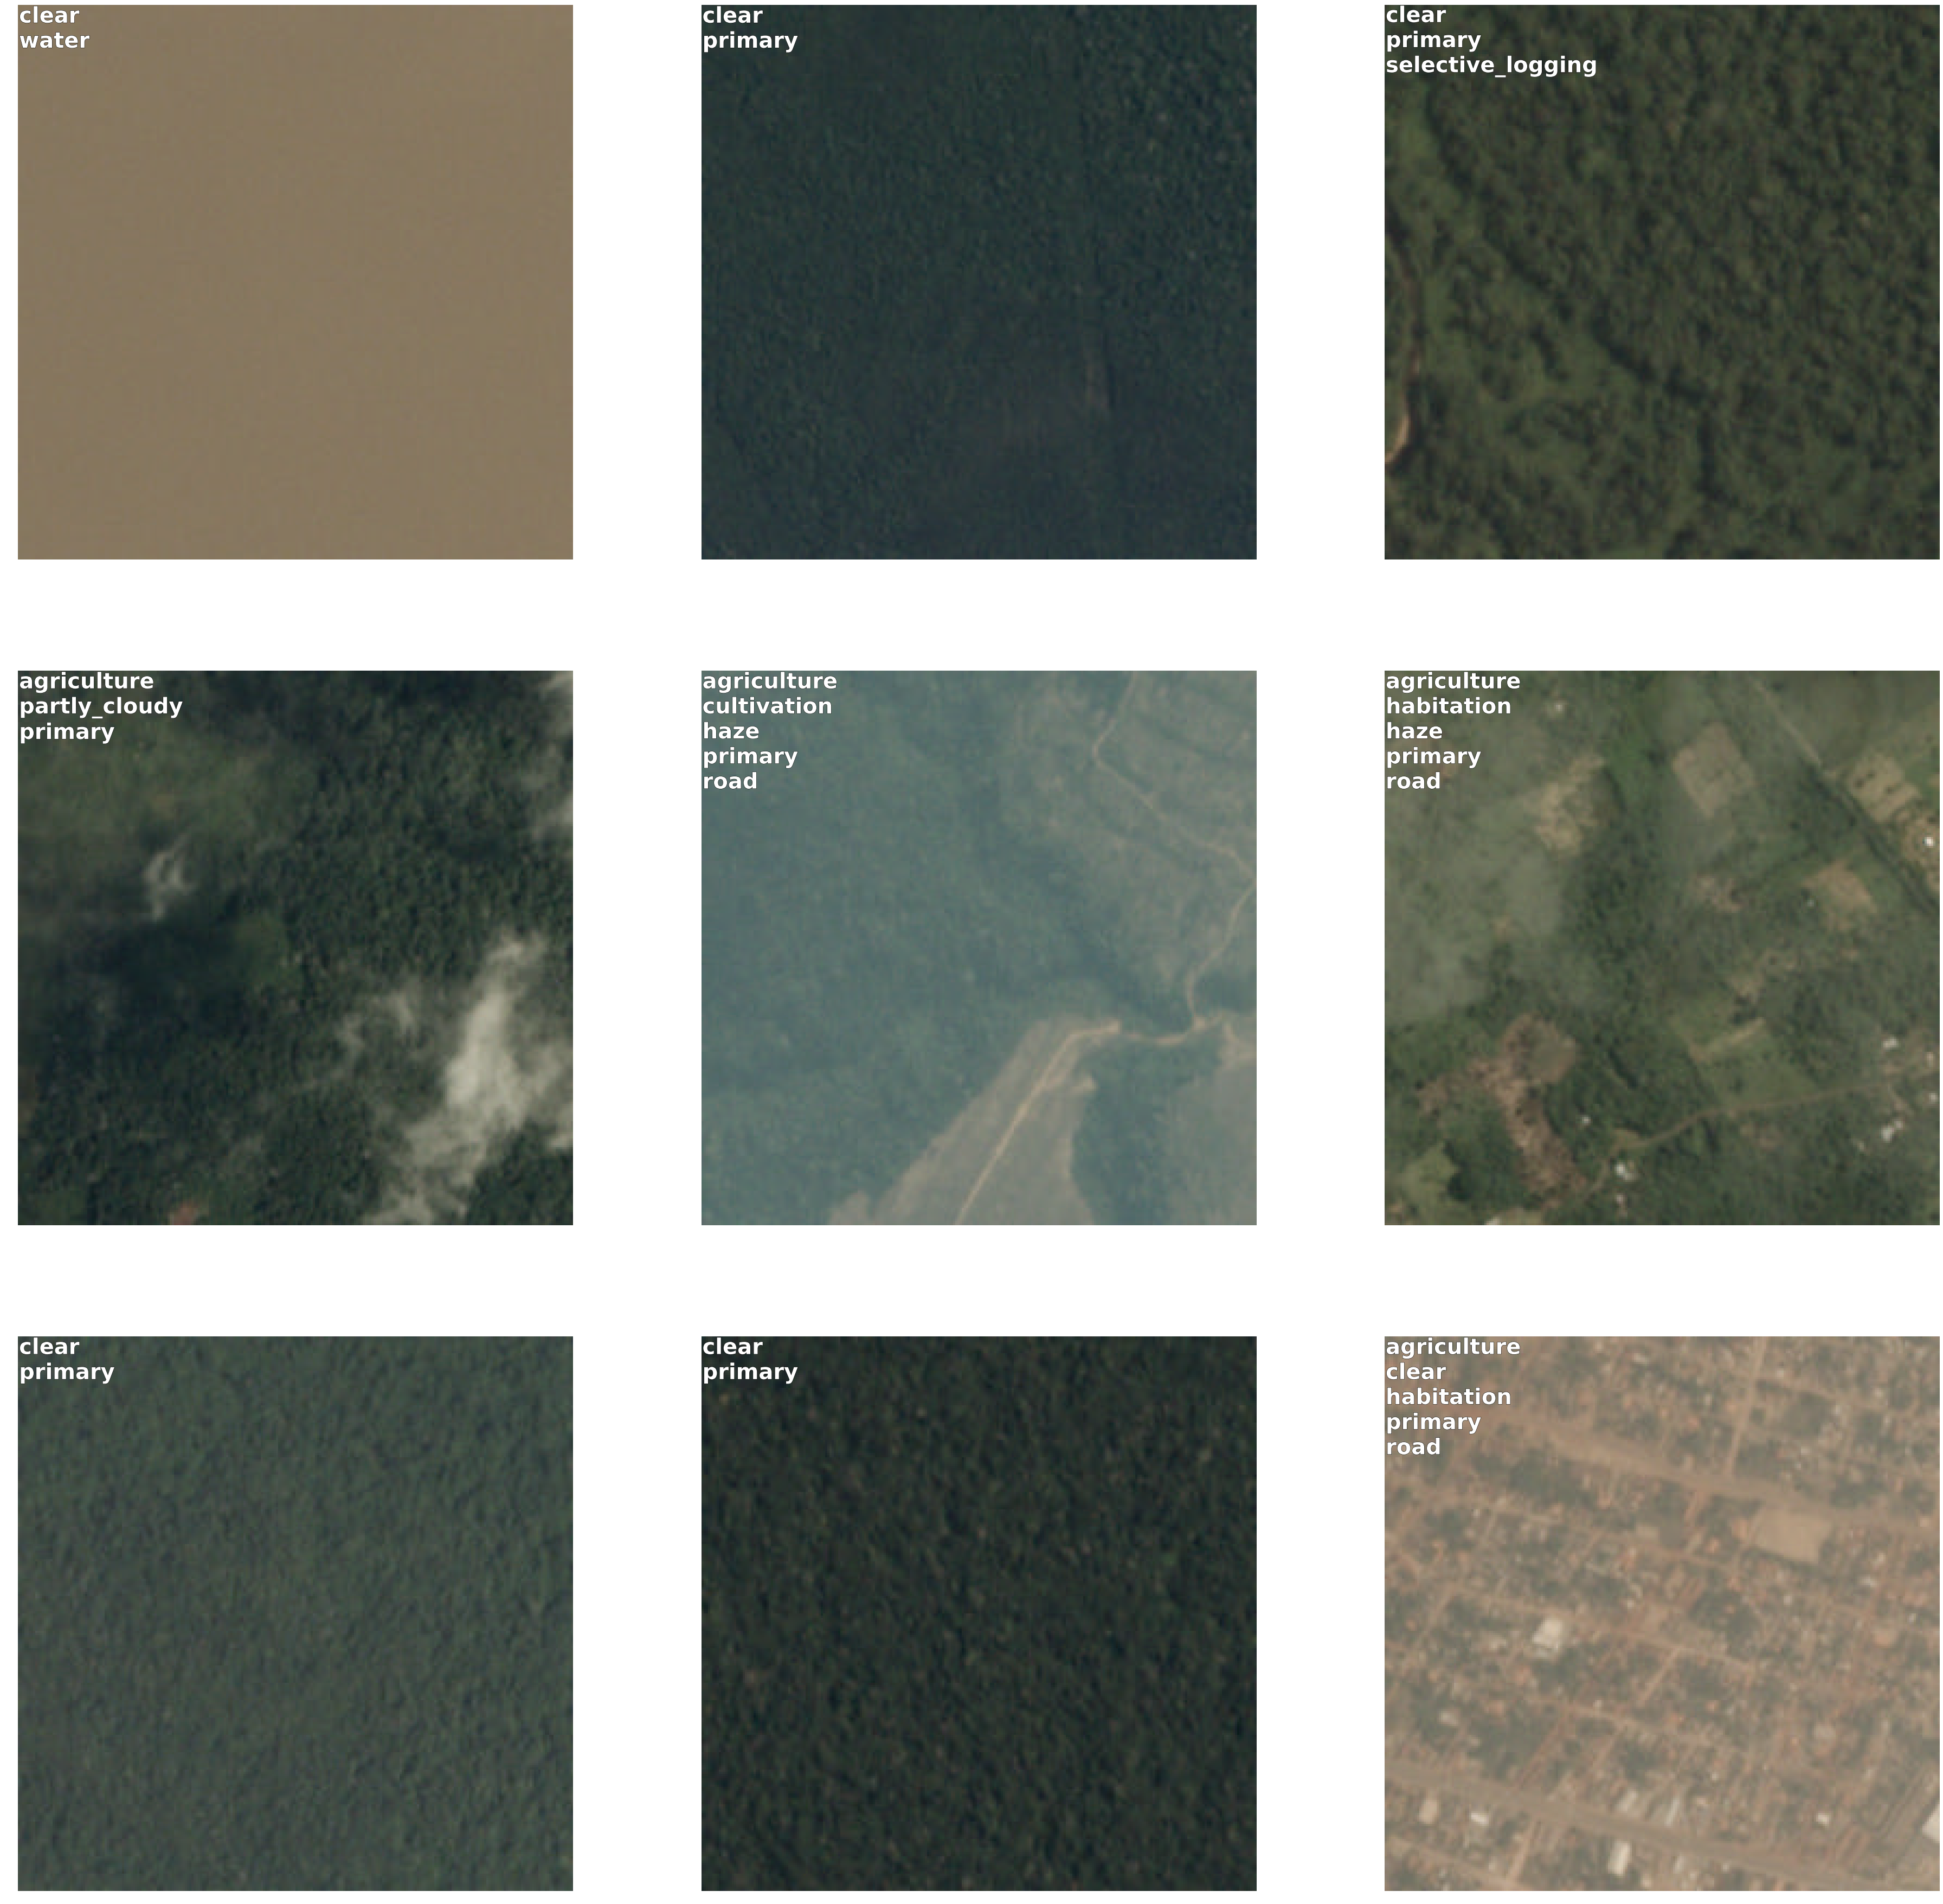

In [8]:
np.random.seed(45)
rands=np.random.randint(0,label_csv.index.size,9)
labs = label_csv.iloc[rands,]
imgs = [open_image(trainpath/(img+'.jpg')) for img in labs.loc[:,"image_name"]]
tags = labs.loc[:,'tags']

show_all_with_labs(imgs,tags,r=3,figsize = (64,64))

Images are RGBA encoded jpegs, size 256x256  
Many pictures show cloud cover which obscures features or generates shadow effects  
In addition, some of these are pretty unclear e.g the water one in the top left and others its not entirely sure they have been classified correctly (bottom right doesn't look much like agriculture to me)


## Build dataset/databunch

Things you should pass to the databunch constructor:
ds_tfms: dataset relevant transforms. Get using get_transforms()
size: size that images will be transformed to.

After constructing the databunch you will also probably want to normalize. Remember, if using a pretrained model normalize to those stats rather than the stats of your dataset

In [8]:
def get_ll(seed=42):
    ll = (ImageItemList.from_df(label_csv, path=trainpath.parent, folder=trainpath.name, suffix='.jpg', cols=0)
                .random_split_by_pct(valid_pct=0.2,seed=seed)
                .label_from_df(label_delim=' ', cols=1))
    return ll
def get_databunch(ll,sz=128,bs=64):
    #pdb.set_trace()
    ds_tfms = get_transforms(flip_vert=True,max_zoom=1.05,max_lighting=0.1,max_warp=0)
    data = ll.transform(tfms=ds_tfms, size=sz).databunch(bs=bs).normalize(imagenet_stats)
    return data

In [9]:
ll = get_ll()

In [10]:
data=get_databunch(ll,sz=128,bs=64)

## Construct model

Here we will be using a pretrained version of the DenseNet architecture (https://arxiv.org/pdf/1608.06993.pdf)  
Model was pretrained on ImageNet, hence us using ImageNet normalization statistics on our dataset.

Our initial setup is as follows:  

Optimizer: AdamW opt function (with corrected weight decay)  
Loss function: Binary cross entropy (this is a multi-class classification)
weight decay: 0.01

Note: remember to add relevant metrics. Here we use f2 score (competition metric) as well as accuracy (threshold 20%) 

In [16]:
MODNAME = 'dnn-169'

def get_learner(arch=densenet169,data=data,extra_metrics = []):
    #pdb.set_trace()
    acc_thresh = partial(accuracy_thresh,thresh=0.2)
    f2 = partial(fbeta,thresh=0.2,beta=2)
    metrics = [acc_thresh,f2] + extra_metrics
    np.random.seed(42)
    learn = create_cnn(data=data,arch=arch,cut=None,pretrained=True,lin_ftrs=[512],ps=[0.25,0.5],
                      split_on=None,metrics=metrics)
    return learn
learn = get_learner(densenet169)

/opt/conda/envs/fastai/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.torch/models/densenet169-b2777c0a.pth
100%|██████████| 57365526/57365526 [00:02<00:00, 23861310.08it/s]


# First pass model

## Training schedule

We start with a pretrained model body that has an untrained classification head. We also are using images half the size of the original data (128x128). The model body is currently non-trainable.  
The plan is to follow two passes of the One-Cycle policy at the lower size - first to train the head, then we will unfreeze the rest of the weights and fine tune the model.  

This dataset seems to benefit from larger batch sizes - increasing image size to full resolution and reducing the batch size led to poorer performance. After the initial training we increase bs again to 128 and train for 10 epochs

For one-cycle policy we will use lr schedule of maxlr/25 -> maxlr, and momentum schedule between .85 and .95 Upward lr cycle for 30% of train time and downward past that

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


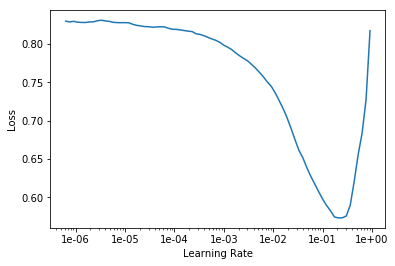

In [13]:
#Find a good learning rate
learn.lr_find()
learn.recorder.plot()

Under the 1-cycle policy we actually get best results when the model spends the first part of training at higher learning rates- just before they spiral out of control. 0.02 might be alright for this one

We pass a slice as the max_lr parameter even though the earlier layers are frozen. This is because by default fastai still allows training of batchnorm


In [14]:
lr = 2e-2
learn.fit_one_cycle(cyc_len=5,max_lr=slice(lr),moms=(0.95,0.85),pct_start=0.3)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.118808,0.104503,0.951982,0.909194
2,0.111952,0.099638,0.954125,0.910908
3,0.105356,0.094433,0.957490,0.918602
4,0.094485,0.086253,0.957745,0.923092
5,0.086378,0.083827,0.957672,0.927336


In [15]:
learn.save(f'1st_cycle-{MODNAME}')
#learn.load(f'1st_cycle-{MODNAME}')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


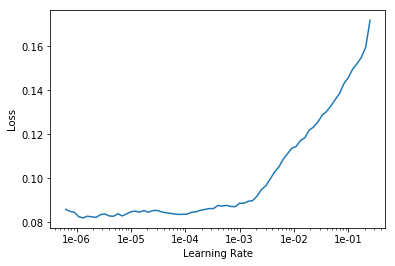

In [16]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [17]:
min_lr=1e-5
max_lr=1e-3
learn.fit_one_cycle(5,slice(min_lr,max_lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.084780,0.083940,0.958638,0.927490
2,0.085433,0.083691,0.959408,0.928005
3,0.083707,0.083236,0.959634,0.928834
4,0.082969,0.083261,0.959299,0.928772
5,0.085592,0.083083,0.959227,0.928562


In [1]:
learn.save(f'2nd_cycle-{MODNAME}')
#learn.load(f'2nd_cycle-{MODNAME}')

In [19]:
learn.data = get_databunch(ll,sz=128,bs=128)
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


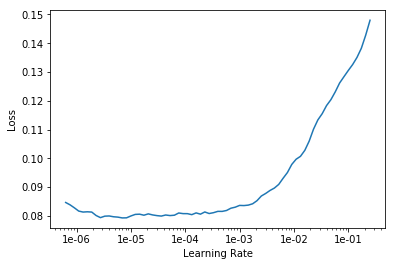

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
min_lr=1e-4
max_lr=3e-3
learn.fit_one_cycle(cyc_len=5,max_lr =slice(min_lr,max_lr),moms=(0.95,0.85),pct_start=0.3)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.083605,0.086627,0.957461,0.925359
2,0.086225,0.084708,0.959459,0.928870
3,0.084976,0.084297,0.959081,0.927548
4,0.080051,0.082527,0.958900,0.928811
5,0.076505,0.082470,0.959714,0.929764


In [22]:
learn.save(f'3rd_cycle-{MODNAME}')
#learn.load(f'3rd_cycle-{MODNAME}')

In [17]:
learn.data = get_databunch(ll,sz=224,bs=40)
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


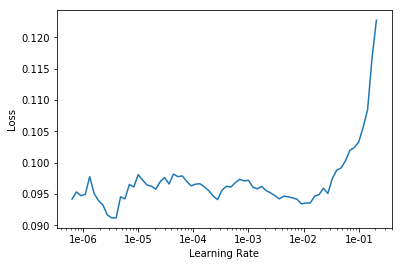

In [24]:
learn.lr_find()
learn.recorder.plot()

In [25]:
min_lr=1e-5/3
max_lr=1e-3
learn.fit_one_cycle(cyc_len=8,max_lr =slice(min_lr,max_lr),moms=(0.95,0.85),pct_start=0.15)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.088770,0.087423,0.956422,0.927303
2,0.086302,0.085282,0.957984,0.927968
3,0.086857,0.084520,0.959707,0.928611
4,0.085807,0.091758,0.958813,0.927445
5,0.086598,0.083941,0.959030,0.929135
6,0.083029,0.083675,0.958173,0.929211
7,0.083170,0.083608,0.958537,0.929559
8,0.083945,0.083968,0.959169,0.928641


In [26]:
learn.save(f'4th_cycle-{MODNAME}')
#learn.load(f'4th_cycle-{MODNAME}')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


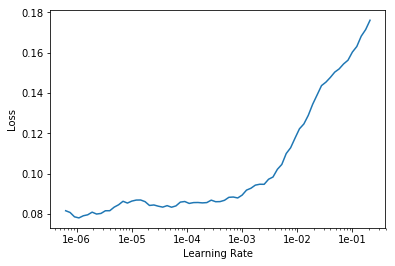

In [27]:
learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

In [28]:
min_lr=1e-5
max_lr=1e-4
(learn.fit_one_cycle(cyc_len=8,max_lr =slice(min_lr,max_lr),moms=(0.95,0.85),pct_start=0.2,
                    callbacks=[SaveModelCallback(learn,name=f'5th_cycle-{MODNAME}_bestmodel')])  )
#The callback here saves the best model based on validation score at the end of an epoch

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.082025,0.082702,0.958791,0.929170
2,0.083194,0.081944,0.959546,0.931196
3,0.079751,0.082736,0.959408,0.930163
4,0.079793,0.081467,0.958733,0.930177
5,0.079918,0.081533,0.960026,0.930733
6,0.078634,0.081955,0.960149,0.929452
7,0.078333,0.081894,0.960063,0.930219
8,0.079575,0.083882,0.960150,0.930480


In [29]:
learn.save(f'5th_cycle-{MODNAME}')
#learn.load(f'5th_cycle-{MODNAME}')

In [1]:
learn.load(f'5th_cycle-{MODNAME}_bestmodel') #this is currently the best one prediction-wise

# Predictions

## Experiment with TTA betas and prediction thresholds

Lets see what kind of results we can get. We have used a threshold in our fbeta of 0.2, but we may be able to do better.  
We'll use test-time augmentation here and experiment with different thresholds

In [24]:
def calc_best_fbeta_thres(y_pred,y_true,view=True,sigmoid=False):
    out = np.zeros(shape=(100,2))
    for i in range(100):
        out[i,0] = i
        out[i,1] = fbeta(y_pred,y_true,sigmoid=sigmoid,thresh=i/100)
    if view:
        plt.plot(out[:,0],out[:,1])
        plt.show()
    best_i = out[:,1].argmax()
    return [best_i/100,out[best_i,1]]
    
def calc_best_ttaweight(y_pred,y_avgpred,y_true,thresh=0.2,view=True):
    #set thresh to None to do a full grid search
    out = np.zeros(shape=(100,2))
    for i in range(100):
        out[i,0] = i
        beta = i/100
        preds = y_pred*beta + y_avgpred*(1-beta)
        out[i,1] = fbeta(preds,y_true,sigmoid=False,thresh=thresh) if thresh else calc_best_fbeta_thres(preds,y_true,view=False)[1]
    if view:
        plt.plot(out[:,0],out[:,1])
        plt.show()
    best_i = out[:,1].argmax()
    return [best_i/100,out[best_i,1]]

In [32]:
probs_val = learn.TTA(ds_type=DatasetType.Valid,beta=None) #setting beta=None means we get back no_TTa preds and avg_TTA preds

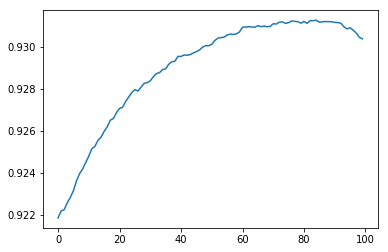

[0.84, 0.9312824010848999]


In [33]:
probs = probs_val
best_ttabeta = calc_best_ttaweight(*probs,thresh=None) 
print(best_ttabeta) # best beta is aroud 0.8

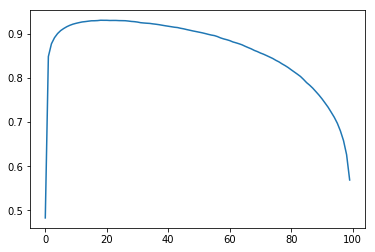

[0.18, 0.9312824010848999]


In [34]:
probs = probs_val[0]*best_ttabeta[0] + probs_val[1]*(1-best_ttabeta[0]) , probs_val[2]
best_thresh = calc_best_fbeta_thres(probs[0],probs[1]) 
print(best_thresh) # best threshold 0.2

In [35]:
#class_thresholds = np.zeros(shape=(17))
#for i in range(17):
#    thresh = calc_best_f1_thres(y_pred=probs_val[0][:,i].unsqueeze(0),y_true=probs_val[1][:,i].unsqueeze(0))
#    thresh = thresh[0]
#    class_thresholds[i]=thresh
#class_thresholds = np2model_tensor(class_thresholds).unsqueeze(0)

## Get test set

In [21]:
testpath1 = path/f'data/test-jpg'
testpath2 = path/f'data/test-jpg-additional'

ll.add_test(ImageItemList(get_files(testpath1) + get_files(testpath2)))
learn.data = get_databunch(ll,sz=224,bs=40)

## Make predictions

In [22]:
probs_test = learn.TTA(ds_type=DatasetType.Test,beta=None)

In [26]:
probs = probs_test[0]*best_ttabeta[0] + probs_test[1]*(1-best_ttabeta[0])
preds = probs.ge(best_thresh[0])

labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p]) for pred in preds]

In [27]:
labelled_preds[:5]

['clear primary',
 'clear primary',
 'clear primary road water',
 'agriculture clear cultivation primary',
 'clear primary']

## Submit predictions

In [28]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items] #last 4 chars are .jpg

In [29]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [30]:
sub_number = 3
df.to_csv(path/f'submissions/submission_{str(sub_number)}.csv', index=False)

In [31]:
subpath = path/f'submissions/submission_{sub_number}.csv'
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {subpath} -m "My submission"

100%|██████████████████████████████████████| 2.20M/2.20M [00:02<00:00, 1.11MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

Private leaderboard score: 0.931 (competiton winner scored 0.933)

# Improvements to model

We'll try and improve the model using some tweaks from different competitions and techniques developed after this competition was finished.  

To do this efficiently we'll run tests on a resnet18 architechture (smaller) as well as using the 128x128 images 

## Baseline

In [120]:
data=get_databunch(ll,sz=128,bs=128)
learn = get_learner(resnet18,data=data)

In [121]:
learn.fit_one_cycle(7,slice(3e-2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.136240,0.118821,0.942027,0.893452
2,0.121223,0.118489,0.953312,0.899837
3,0.116067,0.103557,0.950769,0.911595
4,0.106229,0.097417,0.950296,0.916232
5,0.104475,0.092686,0.952106,0.919541
6,0.096973,0.089834,0.954133,0.920159
7,0.094275,0.088686,0.954380,0.923376


In [122]:
learn.unfreeze()
learn.fit_one_cycle(6,slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.092368,0.088865,0.954700,0.923938
2,0.093260,0.089283,0.951023,0.922024
3,0.089612,0.087391,0.953653,0.923485
4,0.088220,0.085641,0.956807,0.925985
5,0.084745,0.085017,0.955172,0.926007
6,0.083900,0.084767,0.956393,0.925892


In [124]:
learn.export('baseline.pkl')
#learn = load_learner(path/'data','baseline.pkl')
#learn.data = data
#learn.model.cuda()

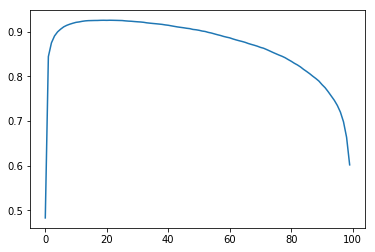

[0.21, 0.9261060357093811]

In [123]:
probs = learn.get_preds()
calc_best_fbeta_thres(*probs)

Baseline model gets minimum val_loss of 0.084767, with indicative f2 score of 0.9261

## Variation 1: Recall weighting in Loss

The competition metric is f2 loss, which weights recall more than precision. We should reflect this in our loss function  
We'll add the regular loss function as a metric so we can compare apples with apples.
The optimal decision threshold in this case may change as well, so we'll investigate that

In [19]:
learn = get_learner(resnet18,data=data,extra_metrics=[F.binary_cross_entropy_with_logits])
learn.loss_func = nn.modules.BCEWithLogitsLoss(pos_weight=as_tensor((2)))


In [15]:
learn.fit_one_cycle(5,slice(3e-2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,binary_cross_entropy_with_logits
1,0.199988,0.165995,0.920256,0.898369,0.124639
2,0.177365,0.156955,0.927995,0.905387,0.113137
3,0.161557,0.148763,0.945377,0.917375,0.099736
4,0.148837,0.135342,0.934011,0.917556,0.098464
5,0.142316,0.133194,0.934244,0.917639,0.096660


In [17]:
learn.unfreeze()
learn.fit_one_cycle(5,slice(5e-6,3e-4))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,binary_cross_entropy_with_logits
1,0.140252,0.132206,0.937958,0.920048,0.094832
2,0.139472,0.131241,0.936540,0.919143,0.095321
3,0.137151,0.129343,0.936126,0.919109,0.094540
4,0.133701,0.128660,0.940276,0.922006,0.092115
5,0.130464,0.128309,0.937499,0.920784,0.093627


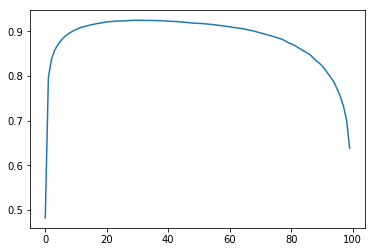

[0.29, 0.9246786236763]

In [22]:
probs = learn.get_preds()
calc_best_fbeta_thres(*probs)

The optimal decision threshold is a bit higher for this formulation, but we only achieve .925 f2 score with this approach - not quite as good as the baseline

## Variation 2: Focal Loss

Focal loss is known to help when we have rare classes in our dataset. We know that the amazon dataset has both common and rare categories, so we can try some focal loss experiments. We'll also need to evaluate optimal decision thresholds here

In [17]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0,alpha=None, logits=True,reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = as_tensor(alpha) if alpha else None
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce
    def forward(self, inputs, targets):
        # I use a different notation for alpha weight than the original FocalLoss paper. >1 means higher weight on
        # positive examples of class
        if self.logits:
            ce = F.binary_cross_entropy_with_logits(inputs,targets,reduction='none',pos_weight=self.alpha)
            inputs = torch.sigmoid(inputs)
        else:
            ce = F.binary_cross_entropy(inputs,targets,reduction='none',pos_weight=self.alpha)
        pt = inputs * targets + (1-inputs)*(1-targets)
        F_loss = (1.-pt)**self.gamma * ce
        
        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [26]:
learn = get_learner(resnet18,data=data,extra_metrics=[F.binary_cross_entropy_with_logits])
learn.loss_func = FocalLoss(1.5,1.25,logits=True)


In [27]:
learn.fit_one_cycle(7,slice(2e-2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,binary_cross_entropy_with_logits
1,0.064421,0.052236,0.864390,0.858557,0.167375
2,0.052701,0.045340,0.831872,0.842782,0.180541
3,0.049545,0.043725,0.881932,0.875329,0.147946
4,0.046930,0.041422,0.883232,0.880392,0.142707
5,0.044152,0.039793,0.889402,0.885119,0.140765
6,0.041540,0.038412,0.883029,0.883938,0.140310
7,0.039952,0.038009,0.888348,0.887972,0.136621


In [28]:
learn.unfreeze()
learn.fit_one_cycle(6,slice(3e-6,4e-4))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,binary_cross_entropy_with_logits
1,0.039534,0.037945,0.889140,0.888748,0.136505
2,0.039705,0.037559,0.889234,0.888791,0.135036
3,0.038595,0.037393,0.891291,0.889079,0.133011
4,0.038325,0.036837,0.893151,0.891432,0.131481
5,0.037631,0.036630,0.892533,0.891363,0.131450
6,0.037069,0.036644,0.892533,0.891172,0.131259


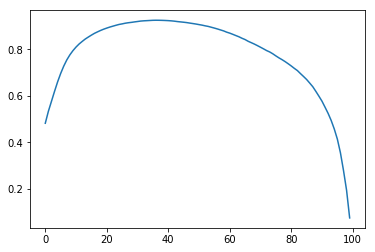

[0.36, 0.924791157245636]

In [29]:
probs = learn.get_preds()
calc_best_fbeta_thres(*probs,sigmoid=True)

a:1 g:1.5 - 0.925  
a:0.75 g:1.5 - 0.924  
a:1 g:2 - 0.924  
a:1 g:2.5 - 0.925  
a:1 g:3 - 0.924


All of the variations on focal loss parameters lead to lower performance also in this dataset

## Variation 3: normalize to data stats

The idea here is to normalize image stats to the train/test set, instead of to ImageNet, to see whether that improves anything

In [42]:
testpath1 = path/f'data/test-jpg'
testpath2 = path/f'data/test-jpg-additional'

trn_tst_iil = ImageItemList(get_files(trainpath)+get_files(testpath1) + get_files(testpath2))


In [104]:
def get_ImageItemList_stats(iil):
    """Returns mean and st_dev by channel, calculating stats from sums as the dataset is probably too
    large to fit in memory"""
    sum_x = torch.zeros((3))
    sumsq_x = torch.zeros((3))
    sz = np.prod(iil[0].size)
    n_img= len(iil)
    n = n_img*sz
    for i,x in enumerate(iil):
        #pdb.set_trace()
        sum_x += x.data.flatten(1).sum(1)
        sumsq_x += x.data.flatten(1).pow(2).sum(1)
        if (i % 1000) == 0: print(f'{i} of {n_img} complete',end='\r')
    mean = sum_x/n
    std = (sumsq_x/n - mean.pow(2)).sqrt()
    return mean,std

#data_stats = get_ImageItemList_stats(trn_tst_iil)  #Takes a while
data_stats = (as_tensor([0.3111, 0.3403, 0.2986]),as_tensor([0.1672, 0.1438, 0.1374]))

In [125]:
ds_tfms = get_transforms(flip_vert=True,max_zoom=1.05,max_lighting=0.1,max_warp=0)
data = ll.transform(tfms=ds_tfms, size=128).databunch(bs=128).normalize(data_stats)
learn = get_learner(resnet18,data=data)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


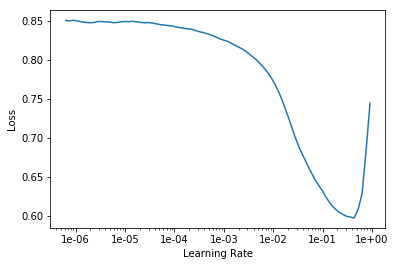

In [119]:
learn.lr_find()
learn.recorder.plot()

In [126]:
learn.fit_one_cycle(7,slice(3e-2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.135617,0.115956,0.940472,0.900211
2,0.120080,0.110502,0.947789,0.901041
3,0.115311,0.102870,0.947477,0.910477
4,0.108945,0.098323,0.954104,0.911732
5,0.100952,0.094482,0.948966,0.919244
6,0.096624,0.089928,0.953632,0.921409
7,0.093369,0.089049,0.953719,0.921977


In [127]:
learn.unfreeze()
learn.fit_one_cycle(6,slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.093739,0.089121,0.955114,0.922273
2,0.094330,0.089579,0.952534,0.921122
3,0.091597,0.087218,0.955971,0.924999
4,0.088034,0.086435,0.955485,0.923362
5,0.084087,0.085097,0.956088,0.925406
6,0.084045,0.084926,0.956516,0.925907


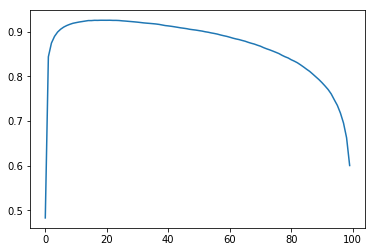

[0.21, 0.9259797930717468]

In [128]:
probs = learn.get_preds()
calc_best_fbeta_thres(*probs)

Best score 0.9260. Basically the same as baseline